In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("unsdsn/world-happiness")

print("Path to dataset files:", path)

Path to dataset files: /Users/pcturnes/.cache/kagglehub/datasets/unsdsn/world-happiness/versions/2


Im gonna be using the data from 2019

In [2]:
import pandas as pd
data = pd.read_csv(f"{path}/2019.csv")

In [3]:
data

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298
...,...,...,...,...,...,...,...,...,...
151,152,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411
152,153,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147
153,154,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025
154,155,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035


In [4]:
cols = {'GDP per capita', 'Social support', 'Healthy life expectancy',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'}

create a new dataset containing only these columns

In [5]:
df = data[list(cols)]

Step 1: Center and scale data

In [6]:
df_scaled_and_centered = (df - df.mean()) / df.std()

Step 2: Calculate the covariance matrix sigma

In [7]:
sigma = df_scaled_and_centered.cov()

Step 3: calculate eigenvectors and eigen values of the matrix

In [8]:
import numpy as np
eigenvalues, eigenvectors = np.linalg.eig(sigma)

sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

Step 4: The proportion of the variance explained by the i-th principal component is given Prop.Var = eigenvalues/sum(eigenvalues)

In [9]:
prop_var = eigenvalues / eigenvalues.sum()

Step 5: The proportion explained by the first k principal components is given by
Cum.Var = cumsum(Eigenvalues)/sum(Eigenvalues)

In [10]:
cum_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

Step 6: calculate the principal components which is the multiplication of the eigenvectors and the variables. And then do the final dataset with the PCAs

In [11]:
pc_scores = df_scaled_and_centered @ eigenvectors

pc_columns = [f"PC{i+1}" for i in range(pc_scores.shape[1])]

pc_df = pd.DataFrame(
    pc_scores.to_numpy(),
    index=data['Country or region'], 
    columns=pc_columns
)

Step 7: Plot the scree plot and the cummulative scree plot to decide how many PCAs to use. We eyeball this using the elbow method.

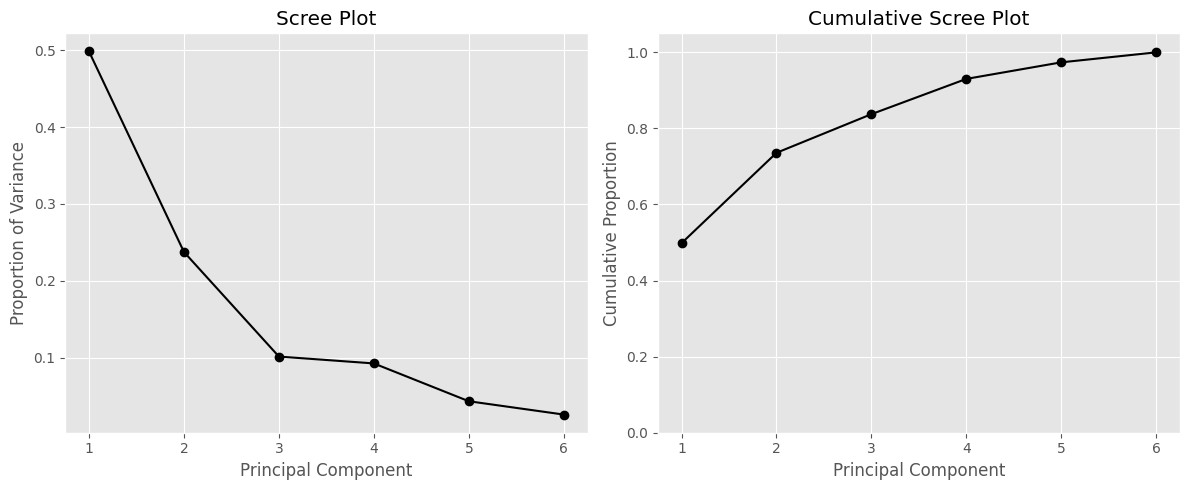

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust x-axis to be 1-based (PC1, PC2...) instead of 0-based
pc_nums = np.arange(1, len(prop_var) + 1)

plt.style.use('ggplot') # Matches the R/ggplot style in your image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Scree Plot
ax1.plot(pc_nums, prop_var, '-o', color='black')
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Variance')
ax1.set_xticks(pc_nums)

# Plot 2: Cumulative Scree Plot
ax2.plot(pc_nums, cum_var, '-o', color='black')
ax2.set_title('Cumulative Scree Plot')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Proportion')
ax2.set_ylim(0, 1.05) # Ensure top is visible
ax2.set_xticks(pc_nums)

plt.tight_layout()
plt.show()

In [13]:
import plotly.express as px
import pandas as pd

# 1. Merge PC scores with the original Happiness Score
# pc_df has countries as index; 'data' should have 'Country or region'
plot_df = pc_df[['PC1', 'PC2']].copy()
plot_df['Happiness Score'] = data.set_index('Country or region')['Score']
plot_df = plot_df.reset_index()

# 2. Create the interactive scatter plot
fig = px.scatter(
    plot_df, 
    x='PC1', 
    y='PC2', 
    hover_name='Country or region',         # Bold title in tooltip
    hover_data={'Happiness Score': ':.2f',  # Show score with 2 decimals
                'PC1': False,                # Hide these if you want a cleaner look
                'PC2': False},
    title='PCA Analysis: Country Happiness Clusters',
    template='plotly_white'
)

# 3. Refine the aesthetics for a "pro" look
fig.update_traces(
    marker=dict(
        size=8,                # Smaller points as requested
        opacity=0.7,           # Slight transparency helps see overlaps
        line=dict(width=1, color='DarkSlateGrey') # Clearer boundaries
    )
)

fig.update_layout(
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    width=900,
    height=600,
    hoverlabel=dict(
        bgcolor="white",
        font_size=14,
        font_family="Arial"
    )
)

fig.show()

In [14]:
from sklearn.cluster import KMeans
import plotly.express as px

# 1. Prepare data for clustering (using the 3 PCs identified)
# Assuming pc_df contains at least PC1, PC2, and PC3
X = pc_df[['PC1', 'PC2', 'PC3']]

# 2. Apply K-Means
# We'll choose n_clusters=3 based on your variance analysis
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pc_df['Cluster'] = kmeans.fit_predict(X).astype(str) # Convert to string for discrete colors

# 3. Merge with Happiness Score for the tooltip
pc_df['Happiness Score'] = data.set_index('Country or region')['Score'].values

# 4. Plot
fig = px.scatter(
    pc_df.reset_index(),
    x='PC1',
    y='PC2',
    color='Cluster',           # Points colored by their identified group
    hover_name='Country or region',
    hover_data={'Happiness Score': ':.2f', 'Cluster': True},
    title='PCA Clusters (K-Means)',
    template='plotly_white',
    color_discrete_sequence=px.colors.qualitative.Safe
)

fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.show()

In [15]:
# Calculate average happiness per cluster
cluster_means = pc_df.groupby('Cluster')['Happiness Score'].mean().sort_values(ascending=False)

print("Average Happiness Score by Cluster:")
print(cluster_means)

Average Happiness Score by Cluster:
Cluster
0    6.728000
2    5.624350
1    4.274479
Name: Happiness Score, dtype: float64
